In [1]:
!git clone https://github.com/tensorflow/tpu/

from IPython import display
from PIL import Image
import numpy as np
# %tensorflow_version 1.x
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

Cloning into 'tpu'...
remote: Enumerating objects: 10970, done.
remote: Counting objects: 100% (1172/1172), done.
remote: Compressing objects: 100% (602/602), done.
remote: Total 10970 (delta 656), reused 1000 (delta 545), pack-reused 9798
Receiving objects: 100% (10970/10970), 46.78 MiB | 30.86 MiB/s, done.
Resolving deltas: 100% (7694/7694), done.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


TPU address is grpc://10.29.19.186:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 7462734271038972748),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 7646793903981987639),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3182331325518405894),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5718646074271963252),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 1391090111278134888),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, -8554025423040965313),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, -2904597692334538419),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, -2354342940772846238),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 22414452

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

preDefPos = [[3,4,1,2,0],[3,2,4,1,0],[2,3,1,4,0],[5,0,1,4,2],[3,0,2,1,-1],[3,2,0,1,-1],[1,2,3,0,4],[0,3,1,4,2],[2,3,1,4,0],[3,1,0,4,2]]
preDefPos2 = [[2,1,0],[2,1,0],[2,0,1],[2,0,1],[2,1,0],[1,0,2],[1,2,0],[0,2,1],[1,2,0],[2,1,0],[1,2,0],[2,1,0],[2,1,0],[0,2,1],[2,1,0],[2,0,1],[2,1,0],[2,1,0],[2,1,0],[2,1,0],[3,1,0],[3,1,0],[3,1,0],[0,2,4],[1,2,4],[1,0,3],[4,1,0],[4,1,0]]
points = np.zeros((10,5,2))
points2 = np.zeros((28,3,2))

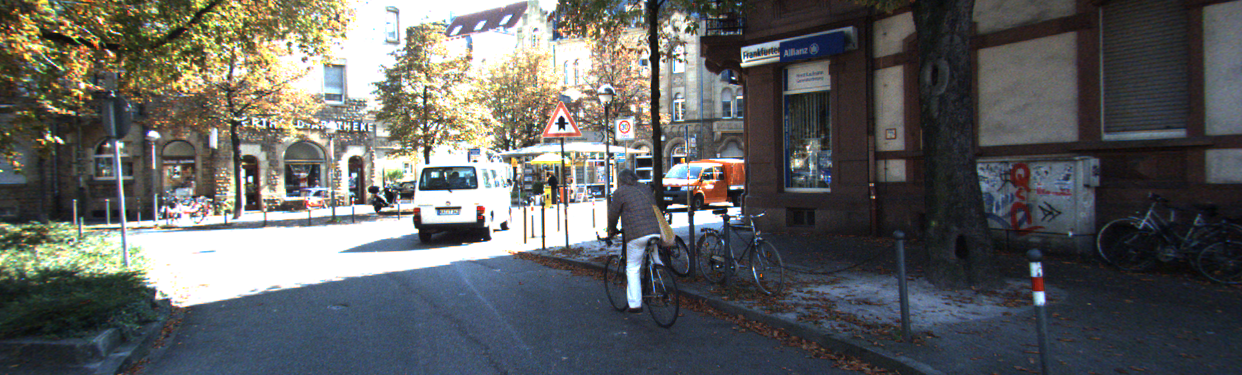

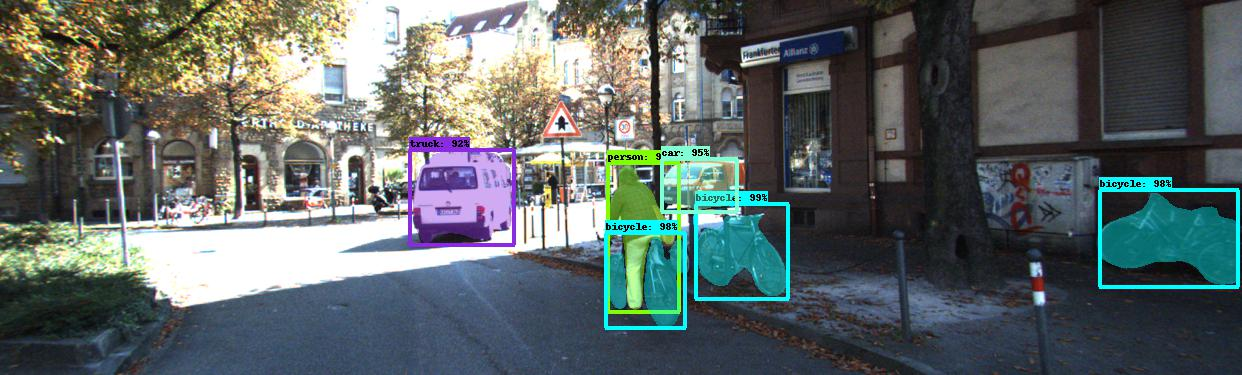

In [6]:
image_path = '000038.png'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.8    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

In [4]:
min_score_thresh = 0.90

for i in range(10):
  image_path = '/content/dat17/0000'+str(24+i)+'.png'

  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])

  image = Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)


  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
      ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
      feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

  
  for j in range(5):
    points[i][j][0] = np.where(segmentations[preDefPos[i][j],:,:]==1)[0].mean()
    points[i][j][1] = np.where(segmentations[preDefPos[i][j],:,:]==1)[1].mean()


FileNotFoundError: ignored

In [ ]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import matplotlib.image as mpimg
cmap = ['r','m','y','g','c']

img = []
for i in range(10):
  image_path = '/content/dat17/0000'+str(24+i)+'.png'
  img.append(mpimg.imread(image_path))

# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
@interact(x=(0, 10))
def double_number(x):
    plt.imshow(img[x]) 
    for i in range(5):
      plt.plot(points[:,i,1],points[:,i,0], color=cmap[i])
      plt.plot(points[x,i,1],points[x,i,0], color=cmap[i], marker='o', markersize=10)
    

      plt.gcf().set_size_inches(1200/370*10, 10, forward=True)
      plt.axis('off')

      plt.xlim(xmin=0,xmax=1200)
      plt.ylim(ymin=370,ymax=0)



interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

In [ ]:
min_score_thresh = 0.90

for i in range(28):
  if i < 10:
    image_path = '/content/dat12/00000'+str(i)+'.png'
  else: 
    image_path = '/content/dat12/0000'+str(i)+'.png'

  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])

  image = Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)


  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
      ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
      feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)


  for j in range(3):
    points2[i][j][0] = np.where(segmentations[preDefPos2[i][j],:,:]==1)[0].mean()
    points2[i][j][1] = np.where(segmentations[preDefPos2[i][j],:,:]==1)[1].mean()


In [ ]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import matplotlib.image as mpimg
cmap2 = ['r','m','y','g','c']

img2 = []
for i in range(28):
  if i < 10:
    image_path = '/content/dat12/00000'+str(i)+'.png'
  else: 
    image_path = '/content/dat12/0000'+str(i)+'.png'
  img2.append(mpimg.imread(image_path))

# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
@interact(x=(0, 27))
def double_number(x):
    plt.imshow(img2[x]) 
    for i in range(3):
      plt.plot(points2[:,i,1],points2[:,i,0], color=cmap2[i])
      plt.plot(points2[x,i,1],points2[x,i,0], color=cmap2[i], marker='o', markersize=10)
    

      plt.gcf().set_size_inches(1200/370*10, 10, forward=True)
      plt.axis('off')

      plt.xlim(xmin=0,xmax=1200)
      plt.ylim(ymin=370,ymax=0)



interactive(children=(IntSlider(value=13, description='x', max=27), Output()), _dom_classes=('widget-interact'…

In [ ]:
with open('Xpos0.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,0,1], separator=',', suppress_small=True))

with open('Ypos0.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,0,0], separator=',', suppress_small=True))

with open('Xpos1.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,1,1], separator=',', suppress_small=True))

with open('Ypos1.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,1,0], separator=',', suppress_small=True))

with open('Xpos2.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,2,1], separator=',', suppress_small=True))

with open('Ypos2.txt', 'w') as f:
    f.writelines(np.array2string(points2[:,2,0], separator=',', suppress_small=True))

In [ ]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import matplotlib.image as mpimg
cmap2 = ['r','m','y','g','c']
cmap2 = ['r','m','y','g','c']

img2 = []
for i in range(28):
  if i < 10:
    image_path = '/content/dat12/00000'+str(i)+'.png'
  else: 
    image_path = '/content/dat12/0000'+str(i)+'.png'
  img2.append(mpimg.imread(image_path))

pred = [None,None,None,None,None,None]
with open('x-Pred0.txt', 'r') as f:
    pred[0] = [float(x) for x in f.readline().split(",")]

with open('y-Pred0.txt', 'r') as f:
    pred[1] = [float(y) for y in f.readline().split(",")]

with open('x-Pred1.txt', 'r') as f:
    pred[2] = [float(x) for x in f.readline().split(",")]

with open('y-Pred1.txt', 'r') as f:
    pred[3] = [float(y) for y in f.readline().split(",")]

with open('x-Pred2.txt', 'r') as f:
    pred[4] = [float(x) for x in f.readline().split(",")]

with open('y-Pred2.txt', 'r') as f:
    pred[5] = [float(y) for y in f.readline().split(",")]



# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
@interact(x=(0, 27))
def double_number(x):
    plt.imshow(img2[x]) 
    for i in range(3):

      # plot trajecs from nn and current point
      plt.plot(points2[:,i,1],points2[:,i,0], color=cmap2[i])
      plt.plot(points2[x,i,1],points2[x,i,0], color=cmap2[i], marker='o', markersize=10)

      #plot prediction line
      plt.plot(pred[2*i], pred[2*i+1], 'c.')

      # # plot prediction elipsies
      # for j in range():
      #     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*pred[2][i], ellipseScaling*pred[3][i], alpha=0.3, color = 'g')
      #     ax.add_artist(ellipse)
      #     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*2*pred[2][i], ellipseScaling*2*pred[3][i], alpha=0.3, color = 'g')
      #     ax.add_artist(ellipse)
      #     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*3*pred[2][i], ellipseScaling*3*pred[3][i], alpha=0.3, color = 'g')
      #     ax.add_artist(ellipse)

    

      plt.gcf().set_size_inches(1200/370*10, 10, forward=True)
      plt.axis('off')

      plt.xlim(xmin=0,xmax=1200)
      plt.ylim(ymin=370,ymax=0)

#       with open('xPred.txt', 'r') as f:
#     pred[0] = [float(x) for x in f.readline().split(",")]

# with open('yPred.txt', 'r') as f:
#     pred[1] = [float(y) for y in f.readline().split(",")]

# with open('xCovPred.txt', 'r') as f:
#     pred[2] = [np.sqrt(float(y)) for y in f.readline().split(",")]

# with open('yCovPred.txt', 'r') as f:
#     pred[3] = [np.sqrt(float(y)) for y in f.readline().split(",")]

# fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

# plt.rcParams["figure.figsize"] = (10,10)
# plt.gca().set_aspect('equal', adjustable='box')


# plt.plot(o1.XPosList, o1.YPosList, 'b.', markersize=6)
# plt.plot(meas[0], meas[1], 'r.', markersize=6)
# plt.plot(pred[0], pred[1], 'g.', markersize=6)

# plt.plot(o1.XPosList, o1.YPosList, 'b')
# plt.plot(meas[0], meas[1], 'r')
# plt.plot(pred[0], pred[1], 'g')

# for i in range(len(pred[0])):
#     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*pred[2][i], ellipseScaling*pred[3][i], alpha=0.3, color = 'g')
#     ax.add_artist(ellipse)
#     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*2*pred[2][i], ellipseScaling*2*pred[3][i], alpha=0.3, color = 'g')
#     ax.add_artist(ellipse)
#     ellipse = Ellipse((pred[0][i], pred[1][i]), ellipseScaling*3*pred[2][i], ellipseScaling*3*pred[3][i], alpha=0.3, color = 'g')
#     ax.add_artist(ellipse)


interactive(children=(IntSlider(value=13, description='x', max=27), Output()), _dom_classes=('widget-interact'…

(370.0, 0.0)

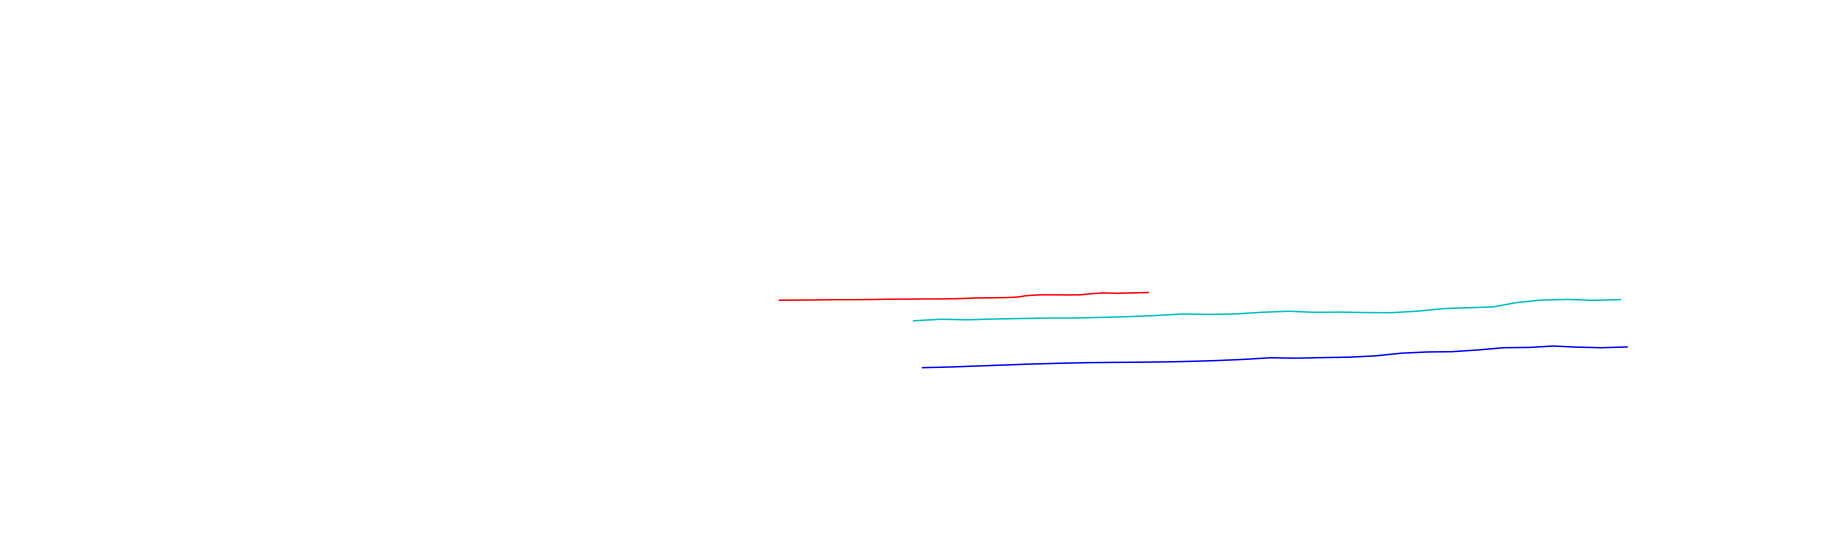

In [ ]:
plt.plot(pred[0], pred[1], 'r')
plt.plot(pred[2], pred[3], 'c')
plt.plot(pred[4], pred[5], 'b')
plt.gcf().set_size_inches(1200/370*10, 10, forward=True)
plt.axis('off')

plt.xlim(xmin=0,xmax=1200)
plt.ylim(ymin=370,ymax=0)